# Seasonal Patterns in Daily Step Counts from iPhone Health Data

## Overview and Driving Question
The project uses my iPhone Health step data to identify patterns in my physical activity across different time periods. The research question is: **What patterns are present in my daily step counts across different days, months, and seasons of the year, and how do these compare to my beliefs about specific active periods?** The process involves converting automatically generated step data into daily statistics, which I will organize and display using various time-based visualizations. This research method is directly applicable as it starts with specific step events, aggregates them into daily statistics, and then compares these statistics across different months and seasons.

## Starting Point

This project began with the goal of exploring my own fitness behavior using real-world data I already collect passively through my iPhone. The starting point came from wondering whether my impressions about being more active during certain times of year were accurate. No external research is being directly followed, but the structure is being modeled after the rubric.

## Source of the Data
The data comes from the **Apple Health** app on my iPhone. Using the built-in “Export All Health Data” feature, I obtained a large XML file called `export.xml` that contains many different health-related records. For this project, I focus specifically on records of type `HKQuantityTypeIdentifierStepCount`, which represent step count measurements recorded by the phone’s motion sensors. This data source is valuable because it is passively and continuously collected, time-stamped, and directly linked to my everyday movement.

## Raw Data Structure and Data Types
In the raw XML file, each step entry is stored as a `<Record>` element with several attributes. The most important attributes for this analysis are:

- `type`: identifies the kind of health measurement (step counts).
- `value`: the number of steps recorded in that interval (stored as text, later converted to numeric).
- `startDate` and `endDate`: timestamps describing when those steps were taken (stored as strings, later parsed as datetimes).
- `sourceName` and `device`: metadata indicating which device recorded the data.

These XML records are read into Python and converted into a pandas DataFrame. From there, I can work with standard data types: datetime objects for times and dates, and integers for step values.

In [12]:
import xml.etree.ElementTree as ET
import pandas as pd

# Parse the XML file
tree = ET.parse("/Users/chris/Desktop/health.xml")
root = tree.getroot()

records = []
for record in root.findall("Record"):
    if record.get("type") == "HKQuantityTypeIdentifierStepCount":
        records.append({
            "type": record.get("type"),
            "unit": record.get("unit"),
            "creationDate": record.get("creationDate"),
            "startDate": record.get("startDate"),
            "endDate": record.get("endDate"),
            "value": int(record.get("value"))
        })

steps_df = pd.DataFrame(records)

# Convert dates to datetime
steps_df["startDate"] = pd.to_datetime(steps_df["startDate"])
steps_df["endDate"] = pd.to_datetime(steps_df["endDate"])
steps_df["creationDate"] = pd.to_datetime(steps_df["creationDate"])

# Add a calendar date column
steps_df["date"] = steps_df["startDate"].dt.date

steps_df.head()

,type,unit,creationDate,startDate,endDate,value,date
0,HKQuantityTypeIdentifierStepCount,count,2025-02-15 16:12:46-05:00,2025-02-15 16:02:38-05:00,2025-02-15 16:04:15-05:00,133,2025-02-15
1,HKQuantityTypeIdentifierStepCount,count,2025-02-15 16:25:47-05:00,2025-02-15 16:14:44-05:00,2025-02-15 16:21:12-05:00,151,2025-02-15
2,HKQuantityTypeIdentifierStepCount,count,2025-02-15 16:38:48-05:00,2025-02-15 16:25:39-05:00,2025-02-15 16:25:49-05:00,4,2025-02-15
3,HKQuantityTypeIdentifierStepCount,count,2025-02-15 16:50:30-05:00,2025-02-15 16:39:27-05:00,2025-02-15 16:41:19-05:00,216,2025-02-15
4,HKQuantityTypeIdentifierStepCount,count,2025-02-15 17:17:56-05:00,2025-02-15 17:07:36-05:00,2025-02-15 17:15:55-05:00,87,2025-02-15


## Collection, Wrangling, and Initial Analysis
At this stage of the project, I have taken the exported XML file and:

1. **Collected**: Used the Apple Health export as my single data source.
2. **Parsed**: Loaded the XML into Python and filtered it so that only step count records are kept.
3. **Typed**: Converted the `startDate` and `endDate` strings into proper datetime objects and the step `value` into numeric type.
4. **Structured**: Stored these records in a pandas DataFrame (`steps_df`) so I can summarize, group, and visualize them.

Next, I explore how many step records I have and what time range they cover, which helps confirm that the data is ready for further analysis.

In [13]:
print("Number of step records:", len(steps_df))
print("Date range:", steps_df["startDate"].min(), "→", steps_df["startDate"].max())

daily_steps = (
    steps_df
    .groupby("date", as_index=False)["value"]
    .sum()
    .rename(columns={"value": "total_steps"})
)

daily_steps

Number of step records: 14263
Date range: 2025-02-15 16:02:38-05:00 → 2025-11-16 16:13:03-05:00


,date,total_steps
0,2025-02-15,853
1,2025-02-16,7878
2,2025-02-17,16250
3,2025-02-18,29036
4,2025-02-19,15114
...,...,...
270,2025-11-12,10999
271,2025-11-13,6408
272,2025-11-14,10124
273,2025-11-15,11429


In [14]:

# Add Season Column
steps_df["month"] = steps_df["startDate"].dt.month
steps_df["year"] = steps_df["startDate"].dt.year

def classify_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

steps_df["season"] = steps_df["month"].apply(classify_season)
steps_df.head()


,type,unit,creationDate,startDate,endDate,value,date,month,year,season
0,HKQuantityTypeIdentifierStepCount,count,2025-02-15 16:12:46-05:00,2025-02-15 16:02:38-05:00,2025-02-15 16:04:15-05:00,133,2025-02-15,2,2025,Winter
1,HKQuantityTypeIdentifierStepCount,count,2025-02-15 16:25:47-05:00,2025-02-15 16:14:44-05:00,2025-02-15 16:21:12-05:00,151,2025-02-15,2,2025,Winter
2,HKQuantityTypeIdentifierStepCount,count,2025-02-15 16:38:48-05:00,2025-02-15 16:25:39-05:00,2025-02-15 16:25:49-05:00,4,2025-02-15,2,2025,Winter
3,HKQuantityTypeIdentifierStepCount,count,2025-02-15 16:50:30-05:00,2025-02-15 16:39:27-05:00,2025-02-15 16:41:19-05:00,216,2025-02-15,2,2025,Winter
4,HKQuantityTypeIdentifierStepCount,count,2025-02-15 17:17:56-05:00,2025-02-15 17:07:36-05:00,2025-02-15 17:15:55-05:00,87,2025-02-15,2,2025,Winter


In [15]:

# Aggregate daily totals and apply seasons
daily_steps = (
    steps_df.groupby("date", as_index=False)["value"]
    .sum()
    .rename(columns={"value": "total_steps"})
)

daily_steps["month"] = pd.to_datetime(daily_steps["date"]).dt.month
daily_steps["season"] = daily_steps["month"].apply(classify_season)

daily_steps.head()


,date,total_steps,month,season
0,2025-02-15,853,2,Winter
1,2025-02-16,7878,2,Winter
2,2025-02-17,16250,2,Winter
3,2025-02-18,29036,2,Winter
4,2025-02-19,15114,2,Winter


## From Raw Records to Daily Totals
The individual step records consist of brief time periods, resulting in multiple daily records for each day. To make the data more understandable, I group it by calendar date and sum the step counts to generate total steps per day. I also include two additional columns tracking the month and season, allowing for future comparisons of daily step counts across different time periods. This daily aggregation serves as the foundation for all subsequent visualizations.

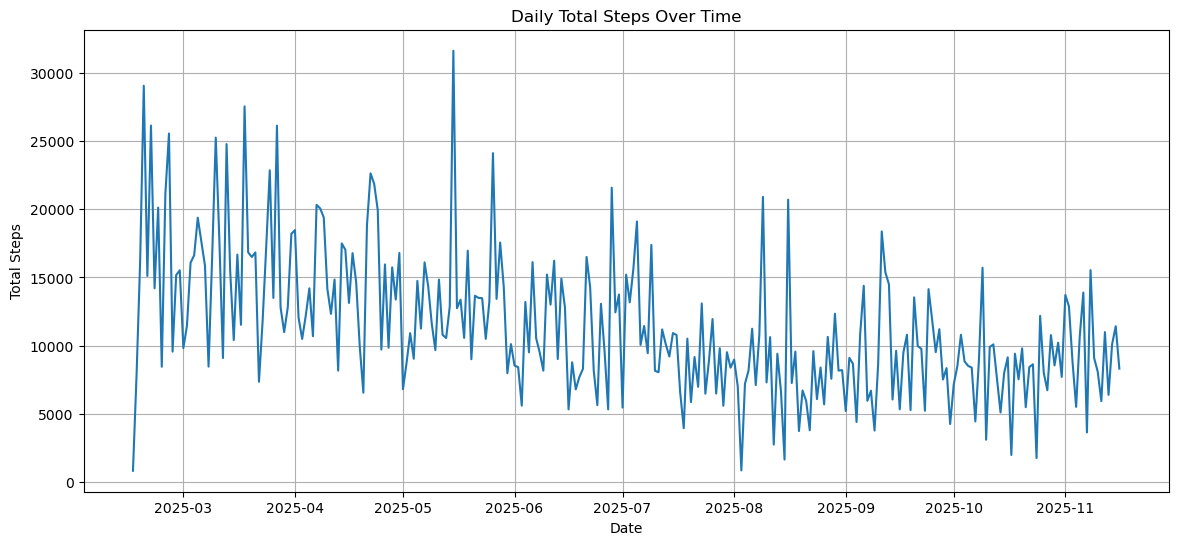

In [16]:

# Daily Steps Over Time 
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(daily_steps["date"], daily_steps["total_steps"])
plt.title("Daily Total Steps Over Time")
plt.xlabel("Date")
plt.ylabel("Total Steps")
plt.grid(True)
plt.show()


### Daily Step Trends
This line plot shows how my total daily steps change over the time period covered by the export. Even without focusing on individual dates, it is possible to see days with noticeably higher or lower activity. These spikes and dips hint at how schedule, routines, or specific events might affect my movement from day to day.

In [17]:

# Average Daily Steps by Month
monthly_avg = daily_steps.groupby("month", as_index=False)["total_steps"].mean()
monthly_avg


,month,total_steps
0,2,16068.642857
1,3,15938.870968
2,4,14923.466667
3,5,13179.870968
4,6,10940.166667
5,7,9961.935484
6,8,8240.838710
7,9,9272.200000
8,10,8123.322581
9,11,9696.875000


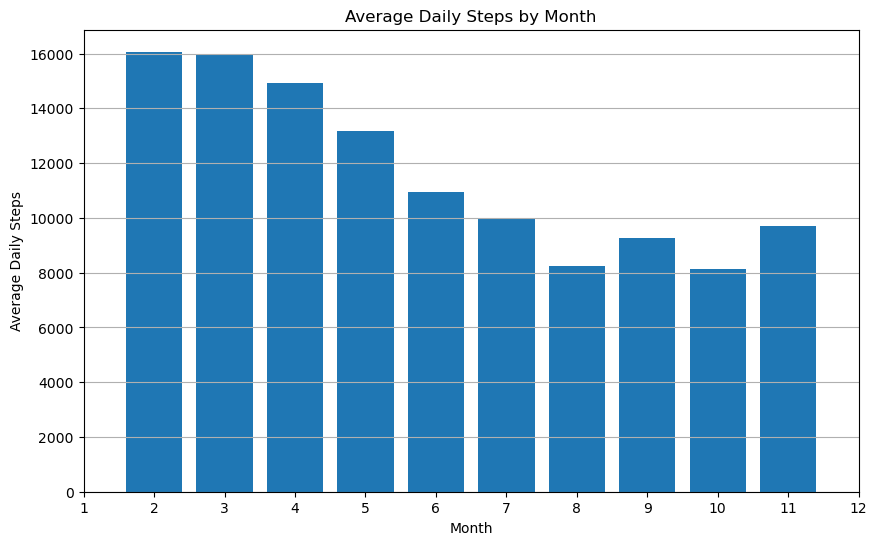

In [18]:

# Bar Chart: Average Steps by Month
plt.figure(figsize=(10,6))
plt.bar(monthly_avg["month"], monthly_avg["total_steps"])
plt.title("Average Daily Steps by Month")
plt.xlabel("Month")
plt.ylabel("Average Daily Steps")
plt.xticks(range(1,13))
plt.grid(axis="y")
plt.show()


## Monthly Step Patterns
The bar chart displaying average daily steps by month illustrates my activity levels throughout the year. By observing the bar heights, I can identify the months with the highest and lowest activity. Patterns in my data appear to correspond with weather changes, as well as with periods when school was in session or on break. While this descriptive analysis highlights which months have the most movement, it does not establish any cause-and-effect relationships.

In [19]:

# Average Daily Steps by Season 
seasonal_avg = daily_steps.groupby("season", as_index=False)["total_steps"].mean()
seasonal_avg


,season,total_steps
0,Fall,8897.909091
1,Spring,14678.097826
2,Summer,9700.989130
3,Winter,16068.642857


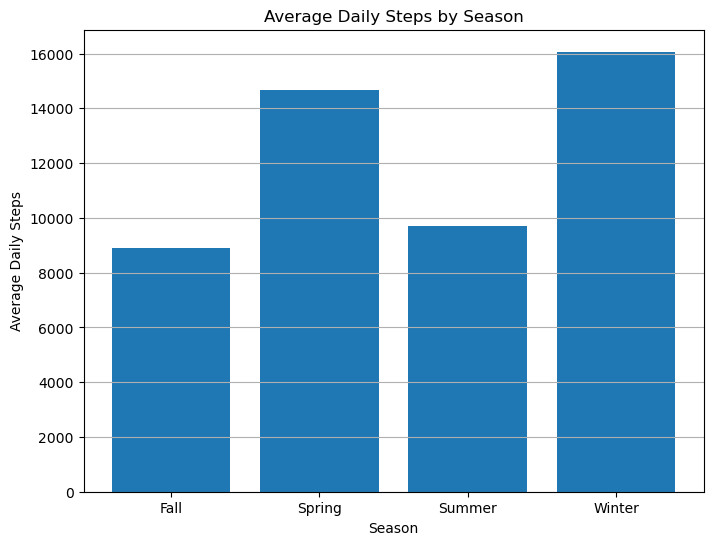

In [20]:

# Bar Chart: Average Steps by Season
plt.figure(figsize=(8,6))
plt.bar(seasonal_avg["season"], seasonal_avg["total_steps"])
plt.title("Average Daily Steps by Season")
plt.xlabel("Season")
plt.ylabel("Average Daily Steps")
plt.grid(axis="y")
plt.show()


## Seasonal Step Patterns and Interpretation
The seasonal grouping method allows me to examine how various seasonal patterns influence the research question regarding seasonal effects on activity. The bar chart displays my average daily step count for each season: Winter, Spring, Summer, and Fall. The clear differences in activity levels across these seasons support the theory that seasonal changes, along with weather patterns and daily routines, impact my physical activity. Presenting these differences quantitatively moves us beyond general impressions to measurable outcomes.

<Figure size 1400x600 with 0 Axes>

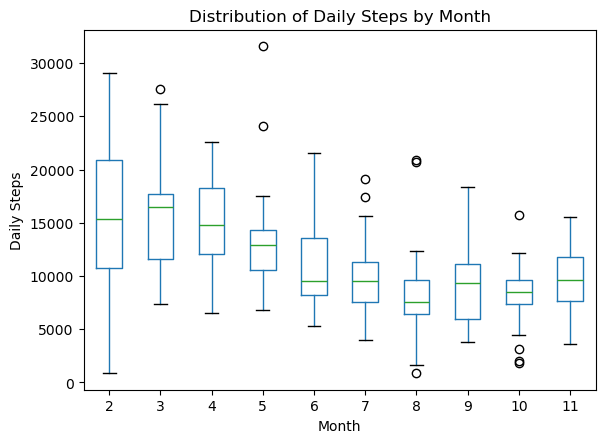

In [21]:

# Boxplot: Steps by Month
plt.figure(figsize=(14,6))
daily_steps.boxplot(by="month", column="total_steps", grid=False)
plt.title("Distribution of Daily Steps by Month")
plt.suptitle("")
plt.xlabel("Month")
plt.ylabel("Daily Steps")
plt.show()


### Variability by Month
The monthly boxplot displays the full range, median, and outliers of daily steps each month, not just averages. This highlights which months have inconsistent activity—mixing very active and inactive days, and which months are steady. Analyzing variability is important, as two months with the same average can offer different experiences if one has more extreme highs and lows.

<Figure size 1000x600 with 0 Axes>

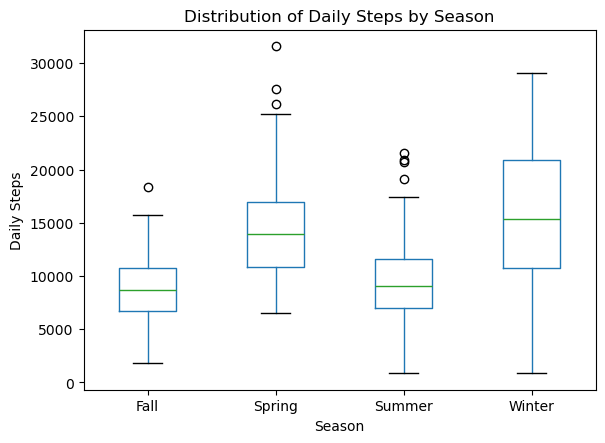

In [22]:

# --- Boxplot: Steps by Season ---
plt.figure(figsize=(10,6))
daily_steps.boxplot(by="season", column="total_steps", grid=False)
plt.title("Distribution of Daily Steps by Season")
plt.suptitle("")
plt.xlabel("Season")
plt.ylabel("Daily Steps")
plt.show()


### Variability by Season
The seasonal boxplot presents data distribution by seasons rather than by months. This analysis illustrates how different seasons impact the number of daily steps, highlighting which seasons have more days with low activity and which have more days with higher activity. The distribution plots complement the bar charts by showing not only average step counts but also the full distribution of my walking data.

## Conclusion, Limitations, and Next Steps
The analysis uses actual step data from my iPhone to illustrate how my daily activities change across different time periods. The results reveal a clear, systematic pattern in my activity levels, observed daily, monthly, and seasonally. These patterns indicate that my activity is not random, as certain times consistently show higher activity levels.

The results reveal clear patterns in activity across days, months, and seasons. The data show that I walk more in the spring and (surpisingly) the winter. This leads to more questions: why would my activity be higher in winter? Am I stressed and therefore walk more? The results of this data analysis surprised me. What are the outliers to the data? How does the iOS Health app accurately track movement? 

There are important limitations to consider. The recorded data only captures activities when I am carrying my phone, missing movements during other times. Additionally, since the study examines just one individual, the results cannot be generalized to the entire population. The analysis uses seasonal data as a basic indicator and does not account for weather, stress, sleep, or other environmental factors.

Future research could integrate step data with other health metrics (such as sleep patterns and heart rate), weather data, and annual comparisons to check for pattern consistency. This project demonstrates that personal data can reveal behavioral patterns over time, but meaningful insights require thorough data collection, processing, visualization, and analysis.

This analysis demonstrates how personal step data can be transformed into meaningful insights about daily and seasonal behavior. Simple metrics like step counts can reveal long‑term patterns, highlight lifestyle habits, and help support more informed decisions about physical activity. This project also opens the door for deeper questions, such as correlations with sleep and mood, or perhaps how accurate the Health app is in the first place.